# 1.8 Multi-Agent 시스템과 RouteLLM

- 앞에서 개발한 `청년월세지원 에이전트`와 `일반답변 에이전트`를 활용해서 다중 에이전트 시스템을 구현합니다

In [1]:
import nest_asyncio
nest_asyncio.apply()

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')
small_llm = ChatOpenAI(model='gpt-4o-mini')

In [3]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list
    answer: str
    
graph_builder = StateGraph(AgentState)

In [4]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Literal

class Route(BaseModel):
    target: Literal['node_parallel_graph', 'self_rag_graph', 'llm'] = Field(
        description="The target for the query to answer"
    )

router_system_prompt = """
당신은 사용자의 질문을 'node_parallel_graph', 'self_rag_graph', 'llm' 중 하나로 라우팅하는 전문가입니다.
'node_parallel_graph'는 청년월세지원 조건에 관한 정보를 포함하고 있습니다.
'self_rag_graph'는 청년월세지원 정보에 관한 내용을 포함하고 있습니다.
질문이 'month_rent_condition_agent'나 'month_rent_information_agent'와 관련이 없다고 판단되면, 'llm'으로 라우팅할 수 있습니다."""

router_prompt = ChatPromptTemplate.from_messages([
    ('system', router_system_prompt),
    ('user', '{query}')
])

structured_router_llm = small_llm.with_structured_output(Route)

def router(state: AgentState) -> Literal['month_rent_condition_agent', 'month_rent_information_agent', 'llm']:
    query = state['query']
    router_chain = router_prompt | structured_router_llm 
    route = router_chain.invoke({'query': query})

    return route.target

In [5]:
from langchain_core.output_parsers import StrOutputParser

def call_llm(state: AgentState) -> AgentState:
    query = state['query']
    llm_chain = small_llm | StrOutputParser()
    llm_answer = llm_chain.invoke(query)
    return {'answer': llm_answer}

In [6]:
from node_parallel_graph import graph as node_parallel_graph
from self_rag_graph import graph as self_rag_graph

graph_builder.add_node('node_parallel_graph', node_parallel_graph)
graph_builder.add_node('self_rag_graph', self_rag_graph)
graph_builder.add_node('llm', call_llm)

/Users/baekseungju/Desktop/02 Python/Study/Baekseung-Agentic-Tutorial/node_parallel_graph.py:77: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_search_tool = TavilySearchResults(


In [7]:
from langgraph.graph import START, END

graph_builder.add_conditional_edges(
    START,
    router,
    {
        'node_parallel_graph': 'node_parallel_graph',
        'self_rag_graph': 'self_rag_graph',
        'llm': 'llm'
    }
)
graph_builder.add_edge('node_parallel_graph', END)
graph_builder.add_edge('self_rag_graph', END)
graph_builder.add_edge('llm', END)

In [8]:
graph = graph_builder.compile()

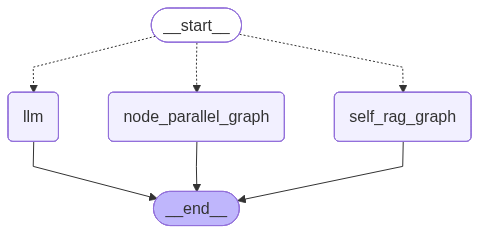

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
initial_state = {'query': '유재석은 청년월세지원 조건에 부합한가요??'}
graph.invoke(initial_state)

{'query': '유재석은 청년월세지원 조건에 부합한가요??',
 'answer': '유재석은 청년월세지원 신청 조건을 충족하지 않습니다. 주요 이유는 다음과 같습니다:\n\n1. **연령**: 유재석은 53세로, 청년(19세에서 39세 이하)에 해당하지 않습니다.\n2. **주택 상황**: 유재석은 고급빌라를 소유하고 있어 무주택 1인 가구가 아닙니다.\n\n따라서, 유재석은 청년월세지원 신청이 불가능합니다.'}

In [11]:
# initial_state = {'query': '청년월세지원 신청 기간은 언제인가요?'}
# graph.invoke(initial_state)

In [12]:
# initial_state = {'query': '떡볶이는 어디가 맛있나요?'}
# graph.invoke(initial_state)